C:\Users\ricar\AppData\Local\Temp\ipykernel_8040\712277240.py:43: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = contour.collections[0].get_paths()


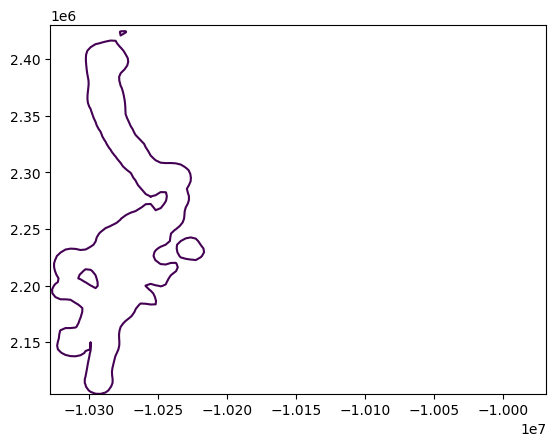

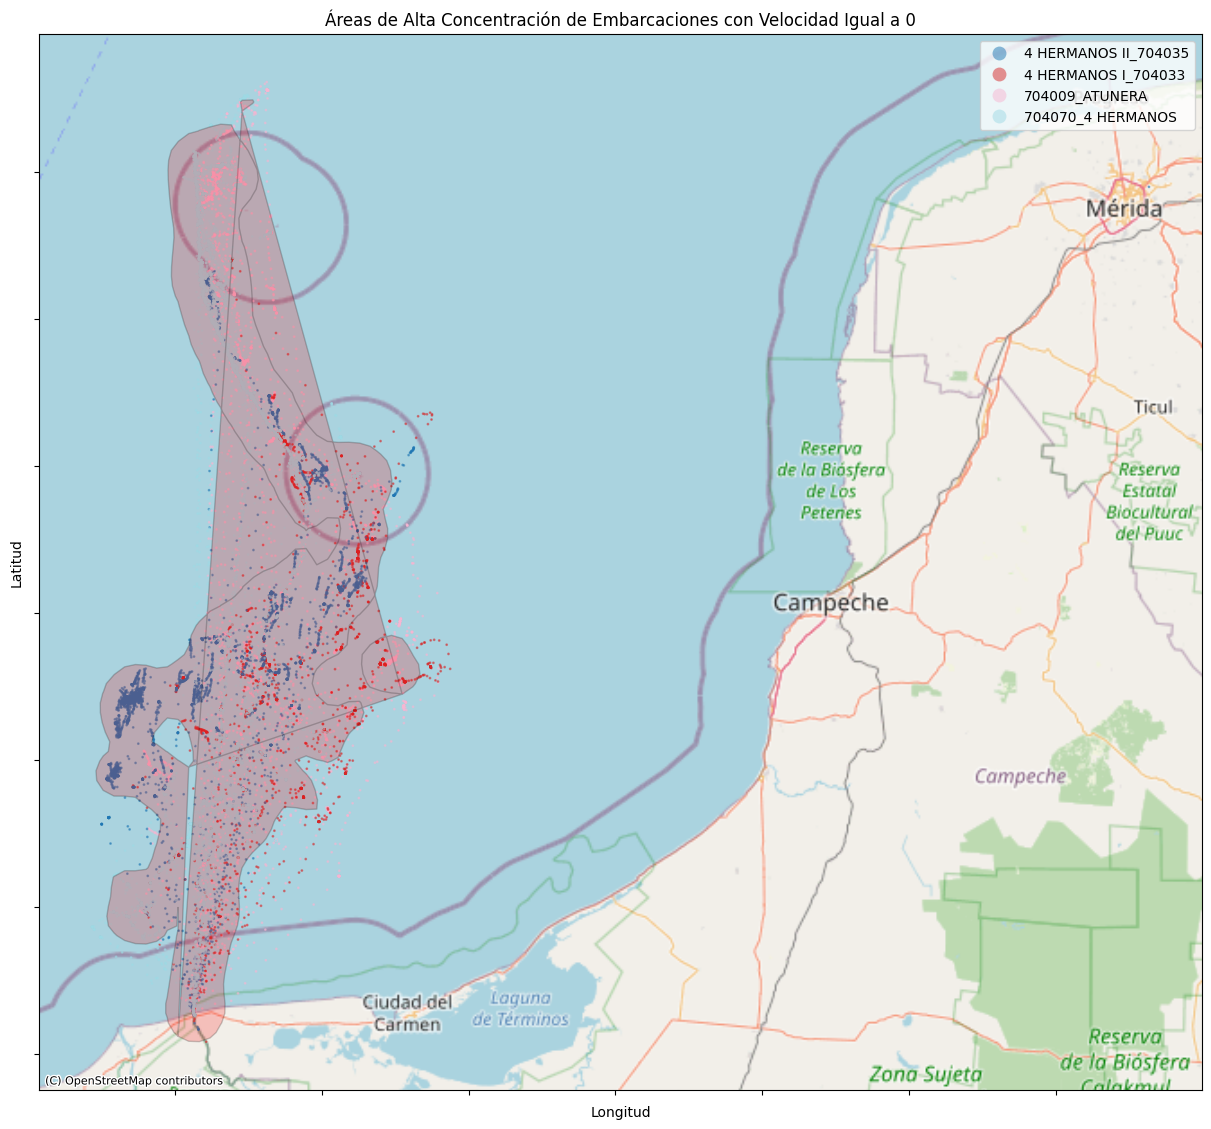

In [27]:
# Importar las bibliotecas necesarias
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import contextily as ctx
from sklearn.neighbors import KernelDensity
import numpy as np

# Cargar el archivo CSV
df = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Filtrar los puntos con velocidad igual a 0
df = df[df['Etapa_Viaje'] != 'Amarre']


# Crear una columna de geometría a partir de las columnas de longitud y latitud
geometry = [Point(xy) for xy in zip(df.Longitud, df.Latitud)]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Convertir el CRS a Web Mercator para usar contextily
gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)

# Convertir los puntos a un array numpy para KDE
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T

# Realizar KDE
kde = KernelDensity(bandwidth=5000, kernel='gaussian')
kde.fit(coords)

# Crear una malla de puntos sobre el área de estudio
x_min, y_min, x_max, y_max = gdf.total_bounds
xgrid = np.linspace(x_min, x_max, 100)
ygrid = np.linspace(y_min, y_max, 100)
x, y = np.meshgrid(xgrid, ygrid)
xy_sample = np.vstack([x.ravel(), y.ravel()]).T

# Evaluar la densidad en cada punto de la malla
z = np.exp(kde.score_samples(xy_sample)).reshape(x.shape)

# Crear un polígono a partir de las áreas de alta densidad
contour = plt.contour(x, y, z, levels=[z.max()*0.1])  # Ajusta el nivel según sea necesario
paths = contour.collections[0].get_paths()
polygons = [Polygon(path.vertices) for path in paths]

# Crear un GeoDataFrame a partir de los polígonos
poly_gdf = gpd.GeoDataFrame(geometry=polygons, crs=gdf.crs)

# Visualizar los datos en un mapa
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(ax=ax, marker='o', markersize=1, column='Nombre_Embarcacion', cmap='tab20', alpha=0.5, legend=True)
poly_gdf.plot(ax=ax, color='red', edgecolor='k', alpha=0.2)

# Añadir el mapa base de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Configurar el título y los ejes del mapa
ax.set_title('Áreas de Alta Concentración de Embarcaciones con Velocidad Igual a 0')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Remover las etiquetas del eje x e y porque contextily usa Web Mercator
ax.set_xticklabels([])
ax.set_yticklabels([])

# Mostrar el mapa
plt.show()



C:\Users\ricar\AppData\Local\Temp\ipykernel_8040\2654904639.py:46: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in contour.collections:
C:\Users\ricar\AppData\Local\Temp\ipykernel_8040\2654904639.py:64: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  poly_gdf.plot(ax=ax, color='red', alpha=0.2)


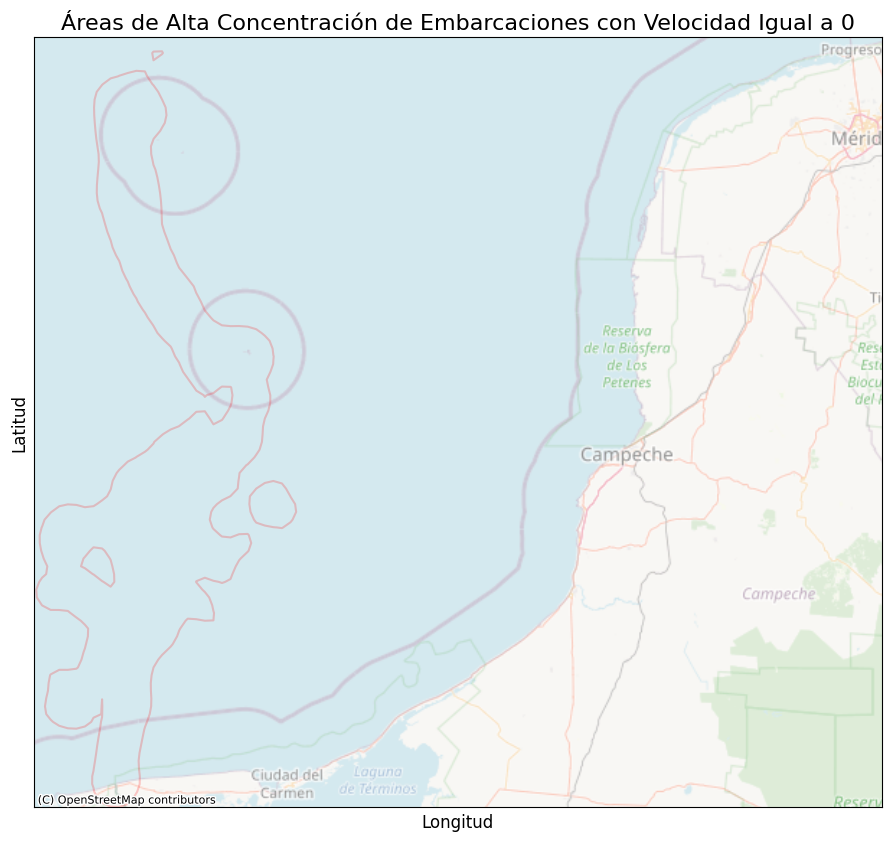

In [29]:
# Importar las bibliotecas necesarias
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import contextily as ctx
from sklearn.neighbors import KernelDensity
import numpy as np

# Cargar el archivo CSV
df = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Filtrar los puntos con velocidad igual a 0
df = df[df['Etapa_Viaje'] != 'Amarre']

# Crear una columna de geometría a partir de las columnas de longitud y latitud
geometry = [Point(xy) for xy in zip(df.Longitud, df.Latitud)]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Convertir el CRS a Web Mercator para usar contextily
gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)

# Convertir los puntos a un array numpy para KDE
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T

# Realizar KDE
kde = KernelDensity(bandwidth=5000, kernel='gaussian')
kde.fit(coords)

# Crear una malla de puntos sobre el área de estudio
x_min, y_min, x_max, y_max = gdf.total_bounds
xgrid = np.linspace(x_min, x_max, 100)
ygrid = np.linspace(y_min, y_max, 100)
x, y = np.meshgrid(xgrid, ygrid)
xy_sample = np.vstack([x.ravel(), y.ravel()]).T

# Evaluar la densidad en cada punto de la malla
z = np.exp(kde.score_samples(xy_sample)).reshape(x.shape)

# Crear contornos a partir de las áreas de alta densidad
fig, ax = plt.subplots(figsize=(15, 10))
contour = ax.contour(x, y, z, levels=[z.max()*0.1], colors='red', alpha=0.2)  # Ajusta el nivel según sea necesario

# Crear polígonos a partir de los contornos
polygons = []
for collection in contour.collections:
    for path in collection.get_paths():
        # Crear un polígono a partir del path
        poly = path.to_polygons()
        # poly es una lista de listas: el primer elemento es el exterior, y los siguientes son agujeros
        exterior = poly[0]
        interiors = poly[1:]
        # Crear un polígono con posibles agujeros
        polygon = Polygon(exterior, interiors)
        polygons.append(polygon)

# Crear un GeoDataFrame a partir de los polígonos
poly_gdf = gpd.GeoDataFrame(geometry=polygons, crs=gdf.crs)

# Filtrar sólo los polígonos válidos (puede haber algunos inválidos debido a la forma de los contornos)
poly_gdf = poly_gdf[poly_gdf.is_valid]

# Plotear los polígonos sin líneas de contorno
poly_gdf.plot(ax=ax, color='red', alpha=0.2)

# Añadir el mapa base de OpenStreetMap con bordes claros
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

# Configurar el título y los ejes del mapa
ax.set_title('Áreas de Alta Concentración de Embarcaciones con Velocidad Igual a 0', fontsize=16)
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

# Remover las etiquetas del eje x e y porque contextily usa Web Mercator
ax.set_xticks([])
ax.set_yticks([])

# Mostrar el mapa
plt.show()




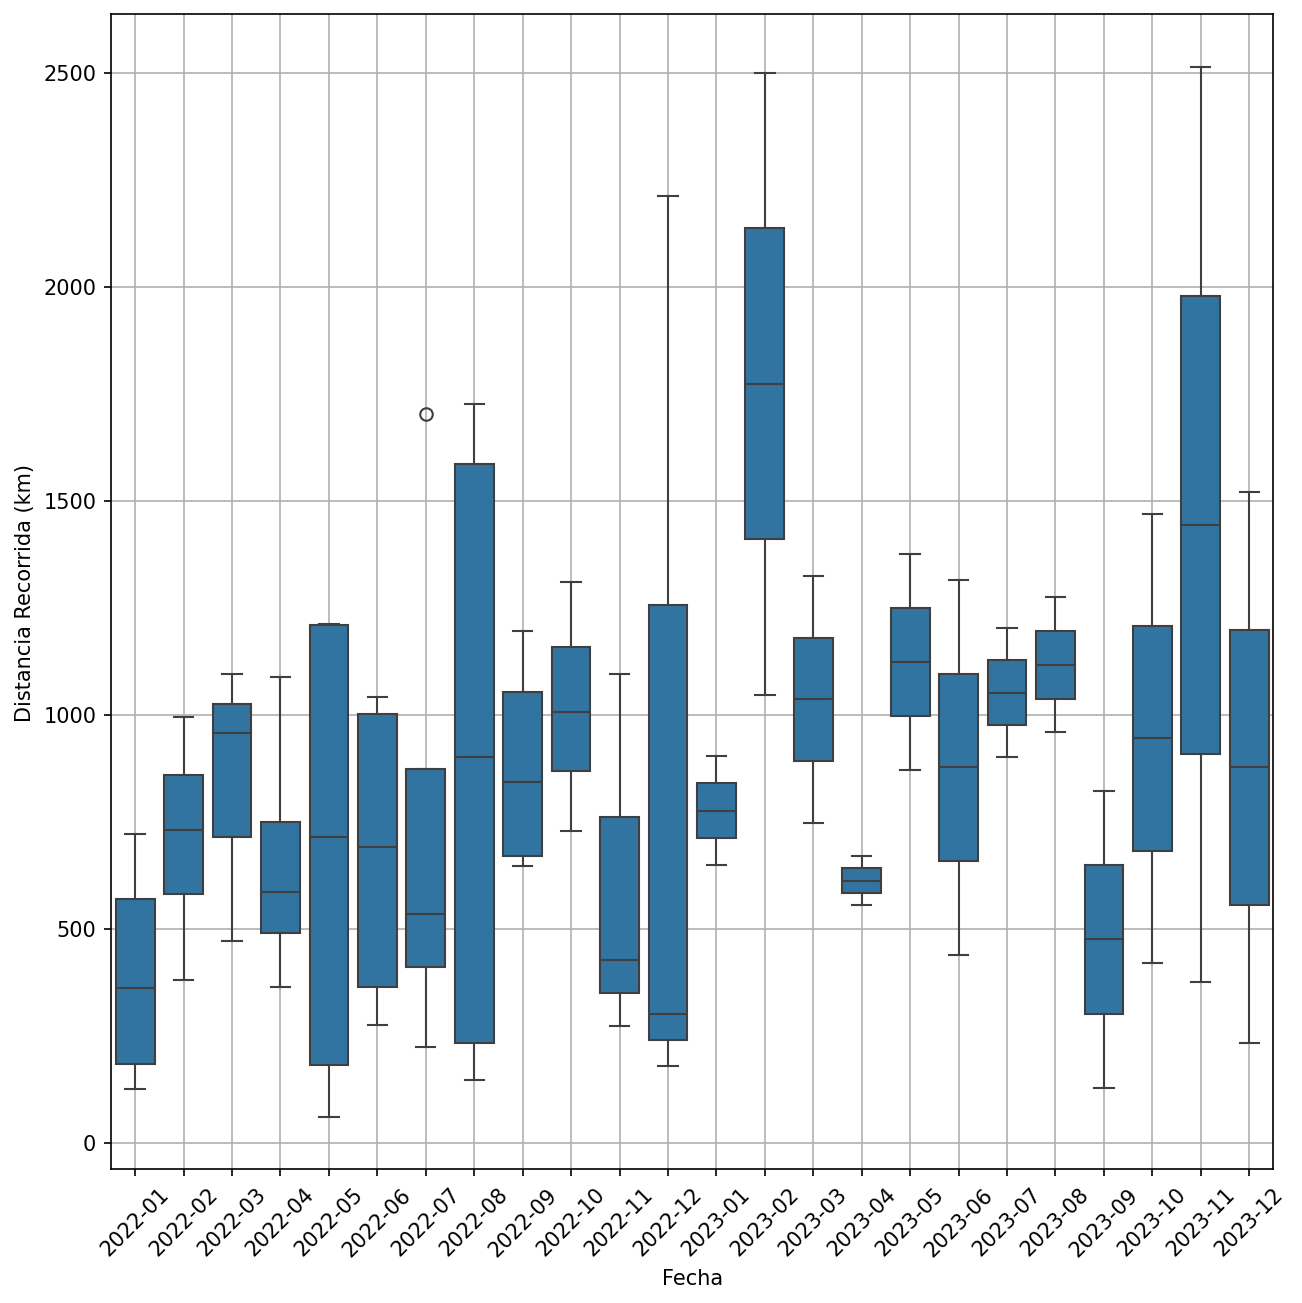

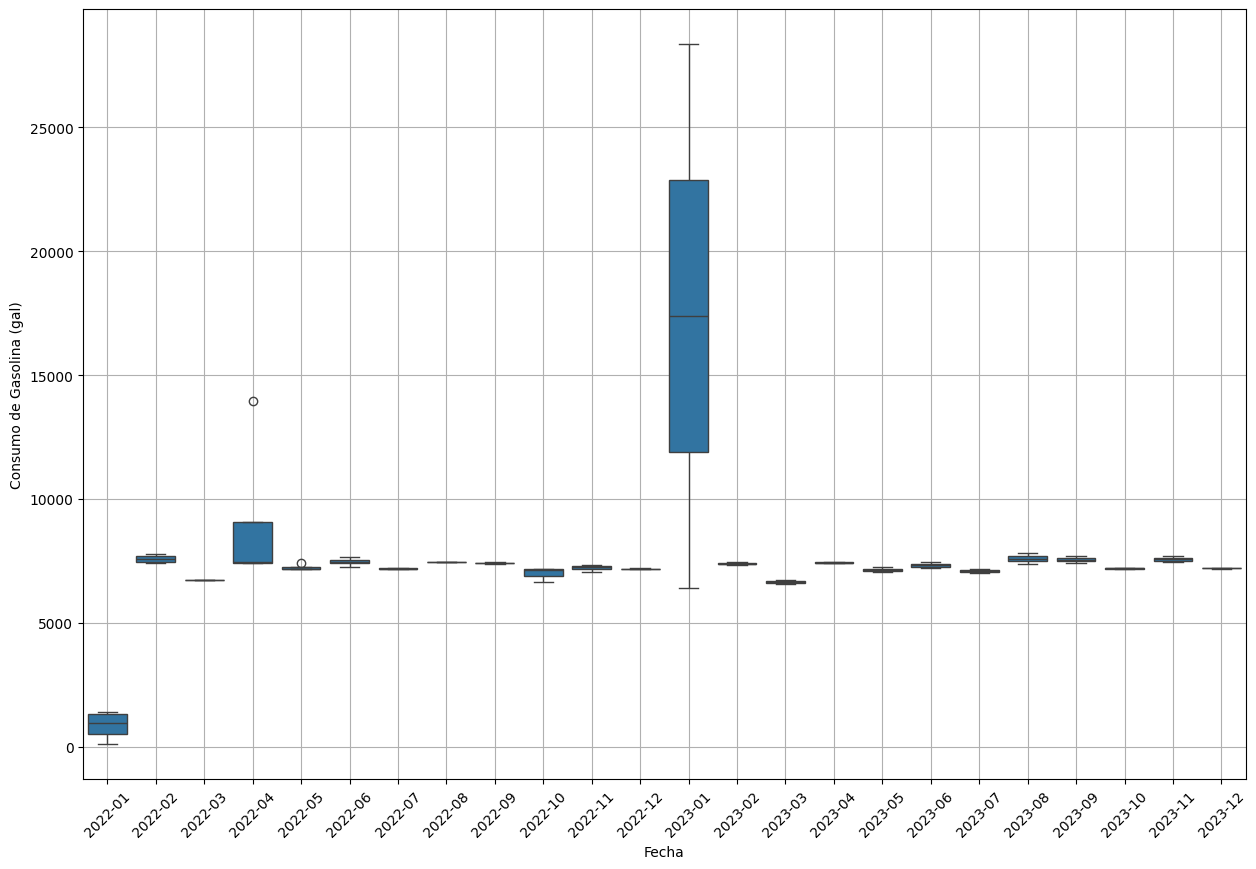

In [58]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
df = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convertir las columnas de fecha y hora a datetime
df['Guardar_Marca'] = pd.to_datetime(df['Guardar_Marca'], errors='coerce')

# Filtrar los puntos con velocidad igual a 0
df = df[df['Etapa_Viaje'] != 'Amarre']

# Ordenar los datos por embarcación y tiempo
df = df.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Crear una columna de geometría a partir de las columnas de longitud y latitud
df['geometry'] = [Point(xy) for xy in zip(df.Longitud, df.Latitud)]
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Calcular la distancia entre puntos consecutivos en el tiempo para cada embarcación
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Reemplazar NaN en las columnas de distancia y tiempo con 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calcular el consumo de gasolina (galones) basado en la potencia del motor y el tiempo de operación
# Asumimos un consumo de 0.1 galones por hora por cada HP
potencia_hp = 100
gdf['Consumo_gal'] = gdf['Tiempo_horas'] * potencia_hp * 0.1

# Crear una columna de año-mes
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M')

# Calcular la distancia total recorrida y el consumo de gasolina mensual por cada embarcación
distancia_consumo_mensual = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_gal': 'sum'
}).reset_index()

# Plotear un boxplot de la distancia recorrida mensualmente para todas las embarcaciones
plt.figure(figsize=(10, 10),dpi=150)
sns.boxplot(x='YearMonth', y='Distancia_km', data=distancia_consumo_mensual)
plt.xlabel('Fecha')
plt.ylabel('Distancia Recorrida (km)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotear un boxplot del consumo de gasolina mensual para todas las embarcaciones
plt.figure(figsize=(15, 10))
sns.boxplot(x='YearMonth', y='Consumo_gal', data=distancia_consumo_mensual)
plt.xlabel('Fecha')
plt.ylabel('Consumo de Gasolina (gal)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


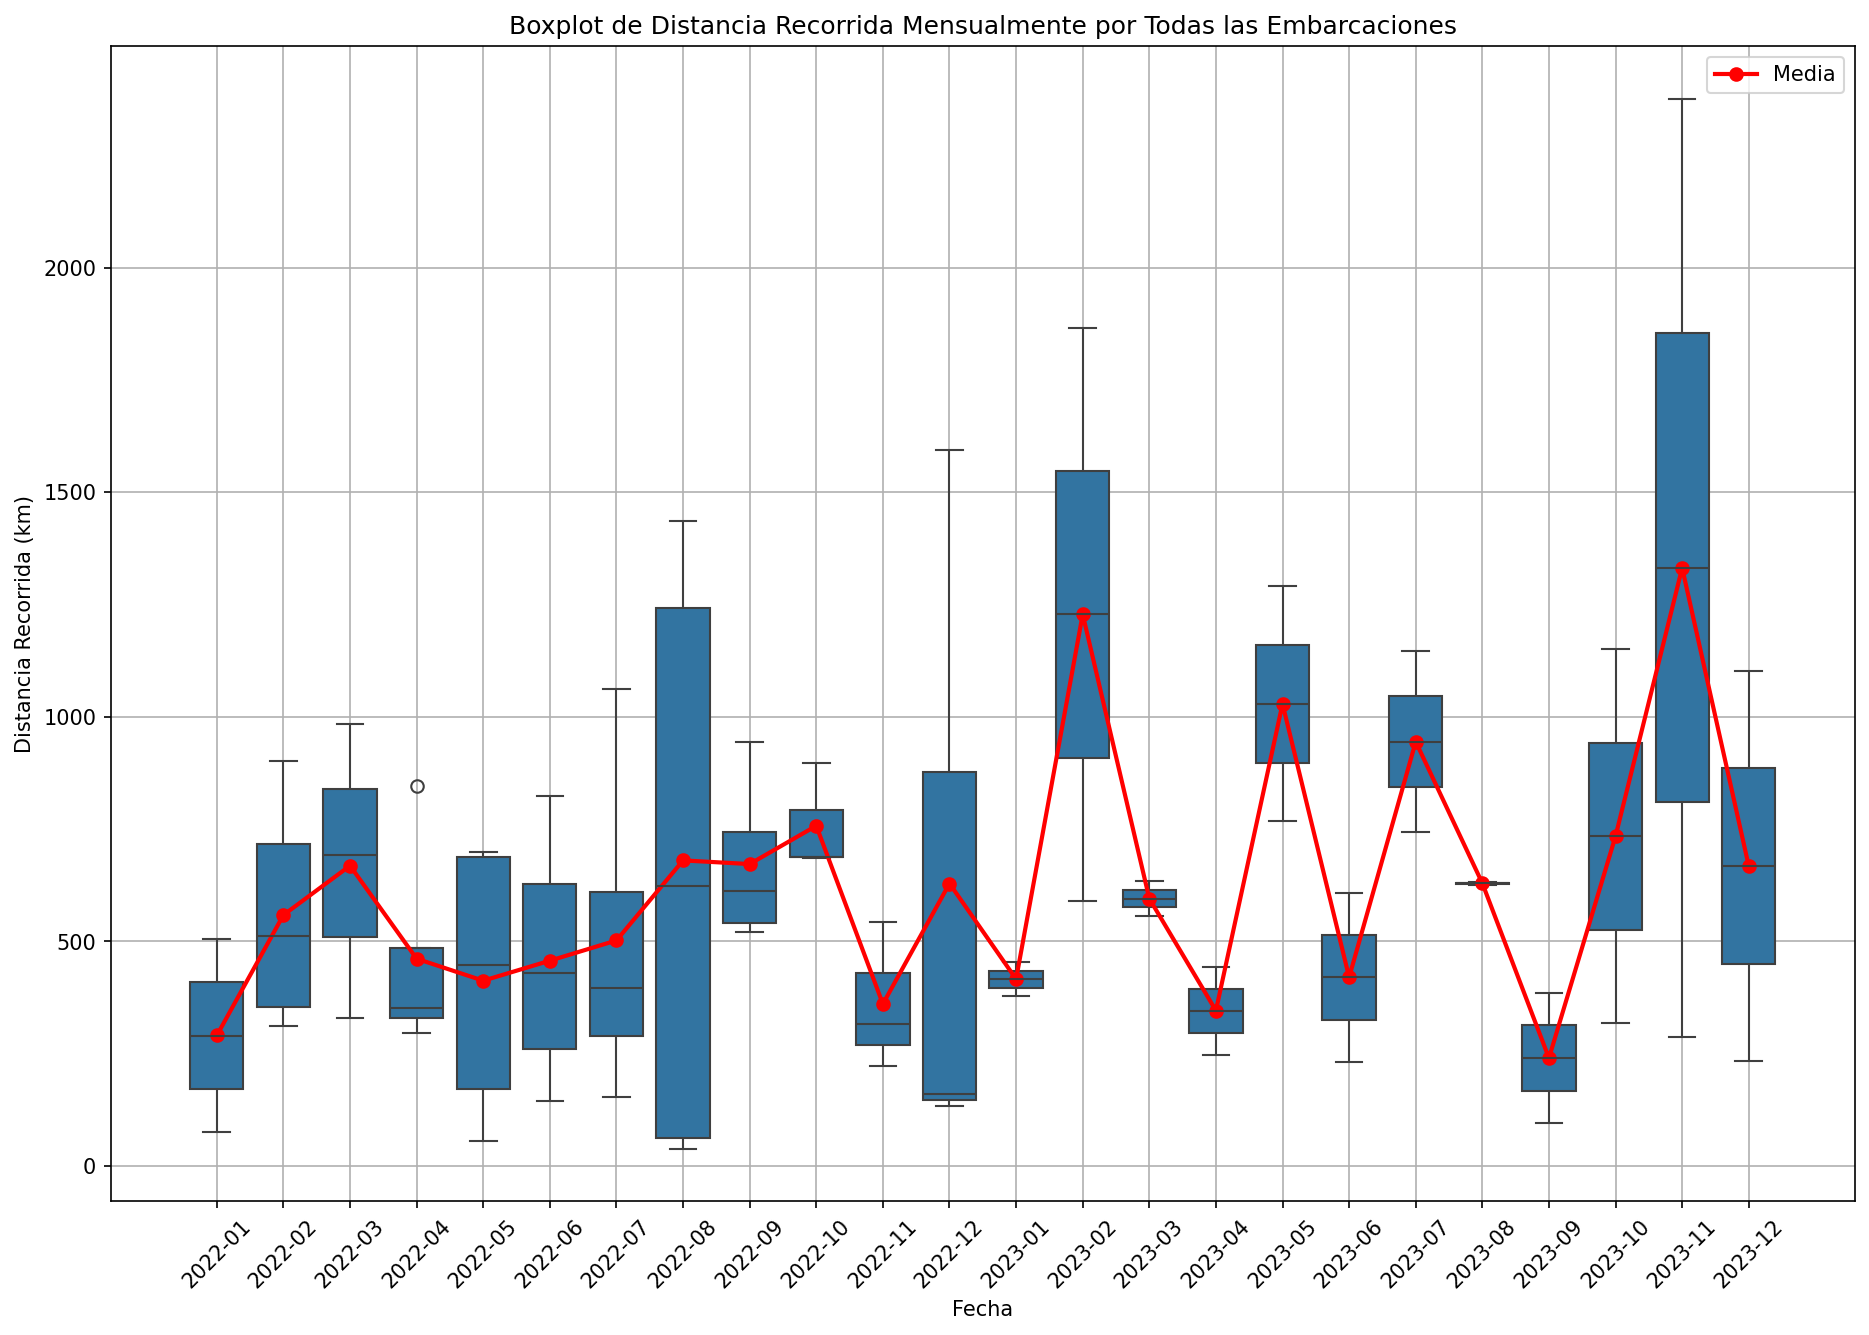

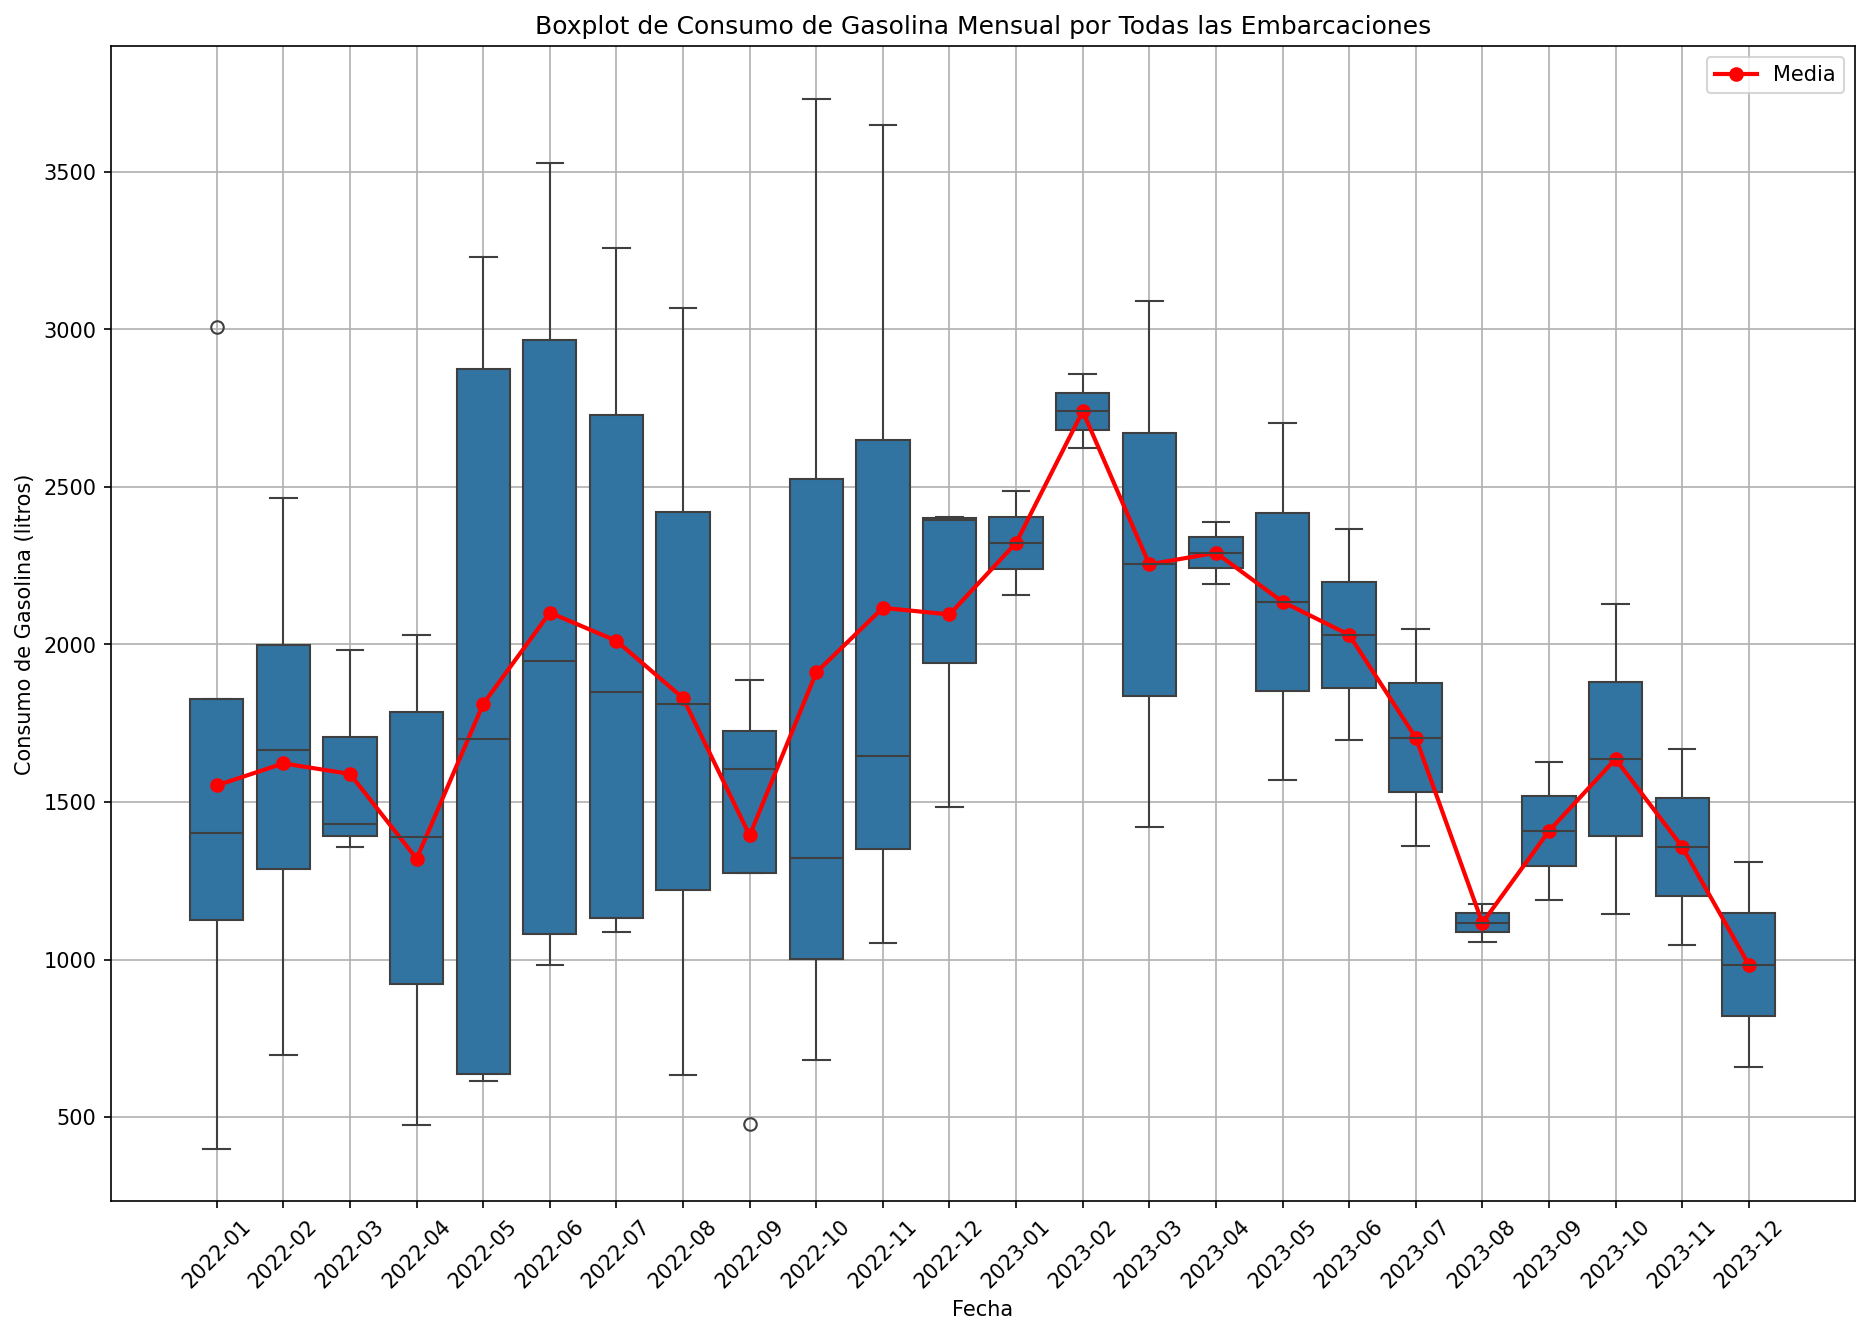

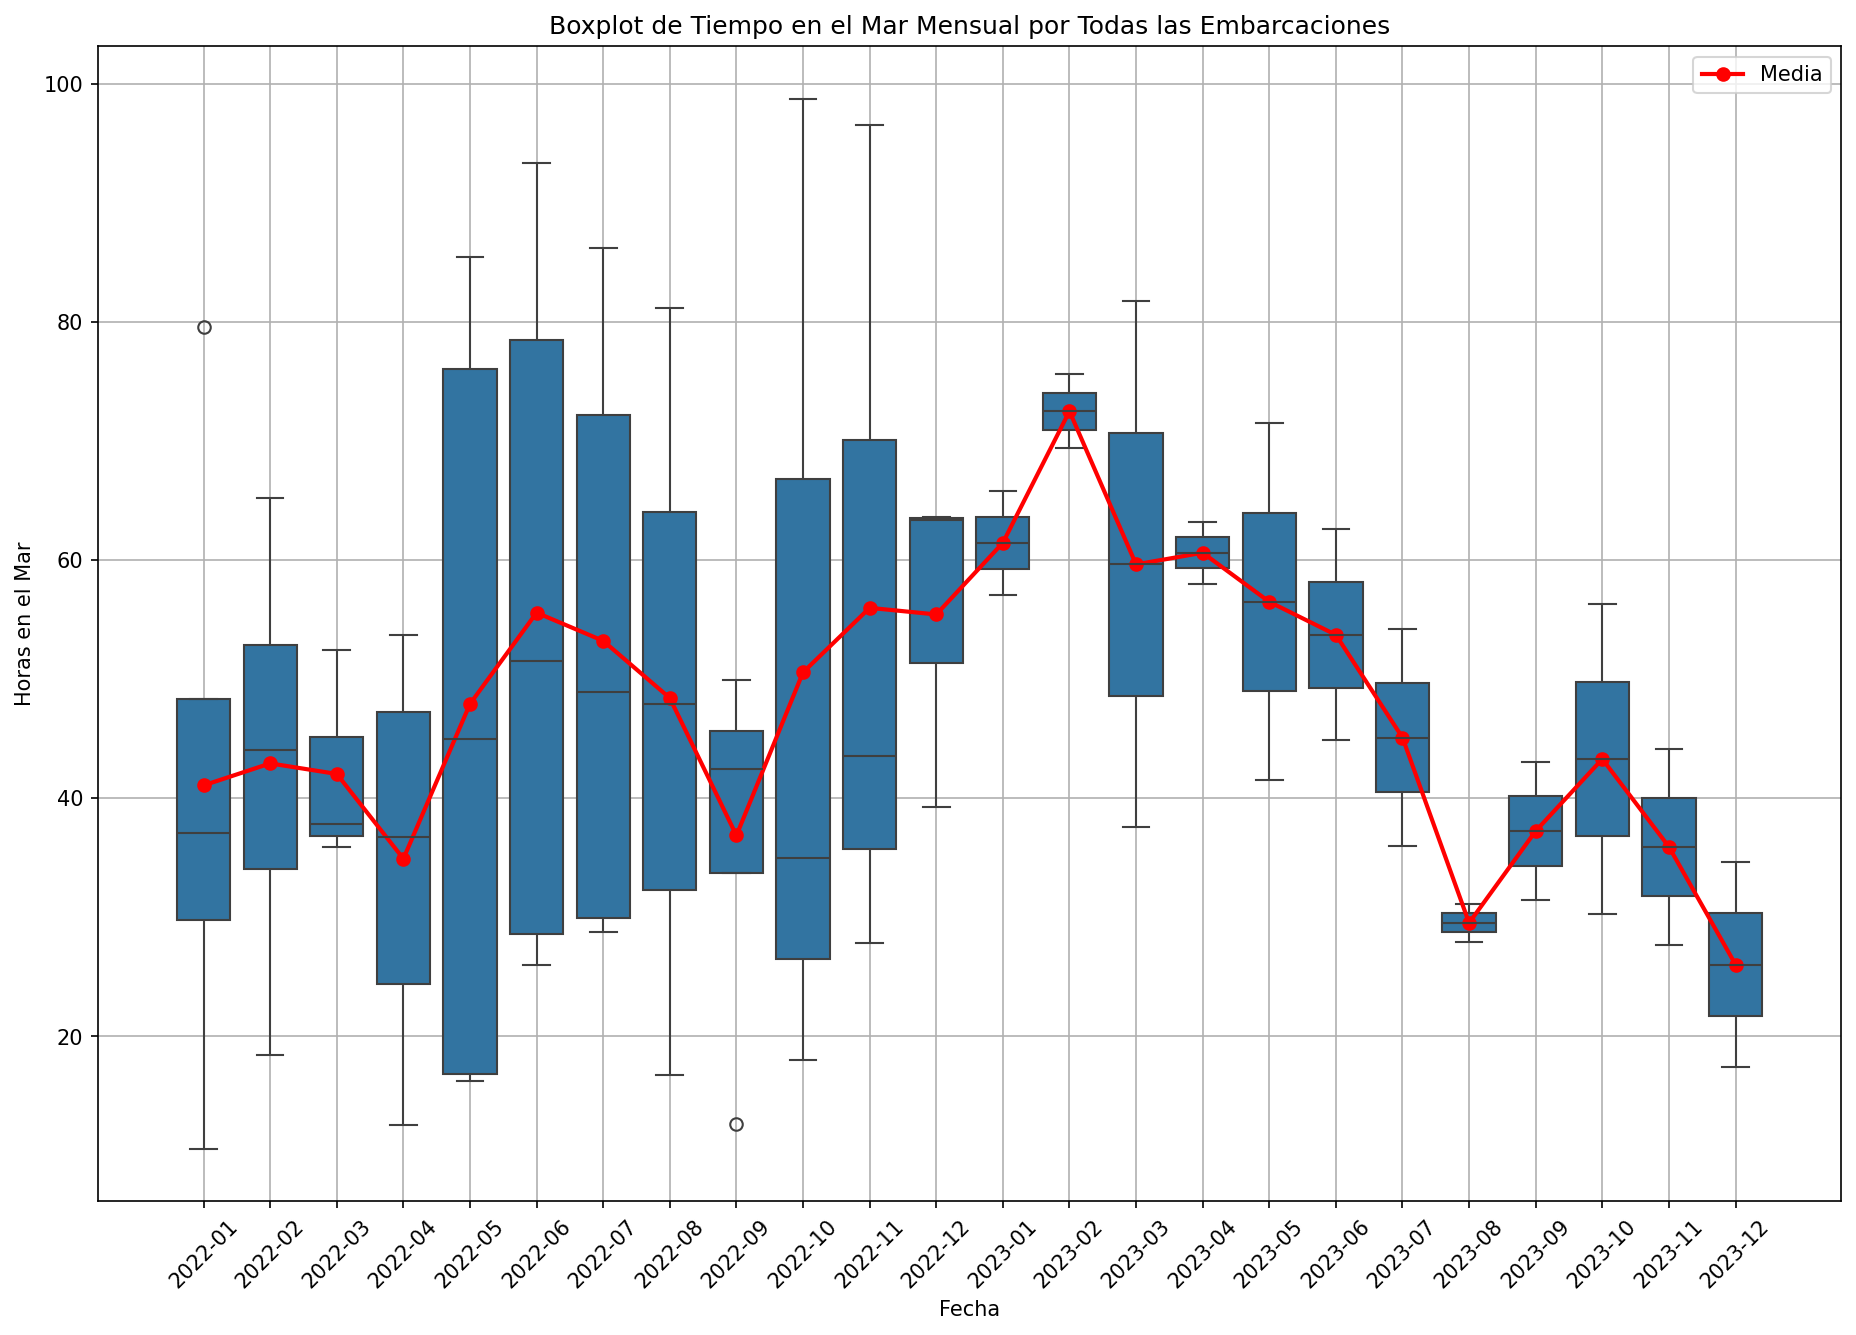

In [13]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
df = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convertir las columnas de fecha y hora a datetime
df['Guardar_Marca'] = pd.to_datetime(df['Guardar_Marca'], errors='coerce')

# Filtrar los puntos con velocidad igual a 0
df = df[df['Etapa_Viaje'] != 'Amarre']

# Ordenar los datos por embarcación y tiempo
df = df.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Crear una columna de geometría a partir de las columnas de longitud y latitud
df['geometry'] = [Point(xy) for xy in zip(df.Longitud, df.Latitud)]
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Calcular la distancia entre puntos consecutivos en el tiempo para cada embarcación
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Reemplazar NaN en las columnas de distancia y tiempo con 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calcular el consumo de gasolina (litros) basado en la potencia del motor y el tiempo de operación
# Asumimos un consumo de 0.1 galones por hora por cada HP, convertido a litros
gal_to_liters = 3.78
potencia_hp = 100
gdf['Consumo_litros'] = gdf['Tiempo_horas'] * potencia_hp * 0.1 * gal_to_liters

# Identificar y eliminar valores anómalos en el consumo de gasolina
# Aquí, se define como anómalo cualquier valor que esté por encima del percentil 99
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Crear una columna de año-mes
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M')

# Calcular la distancia total recorrida, el consumo de gasolina y las horas en el mar mensualmente por cada embarcación
distancia_consumo_mensual = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calcular las medias mensuales de distancia recorrida, consumo de gasolina y tiempo en el mar
medias_distancia = distancia_consumo_mensual.groupby('YearMonth')['Distancia_km'].mean()
medias_consumo = distancia_consumo_mensual.groupby('YearMonth')['Consumo_litros'].mean()
medias_tiempo = distancia_consumo_mensual.groupby('YearMonth')['Tiempo_horas'].mean()

# Plotear un boxplot de la distancia recorrida mensualmente para todas las embarcaciones
plt.figure(figsize=(15, 10), dpi=150)
sns.boxplot(x='YearMonth', y='Distancia_km', data=distancia_consumo_mensual)
plt.plot(medias_distancia.index.astype(str), medias_distancia.values, color='red', marker='o', linestyle='-', linewidth=2, label='Media')
plt.title('Boxplot de Distancia Recorrida Mensualmente por Todas las Embarcaciones')
plt.xlabel('Fecha')
plt.ylabel('Distancia Recorrida (km)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Plotear un boxplot del consumo de gasolina mensual para todas las embarcaciones
plt.figure(figsize=(15, 10), dpi=150)
sns.boxplot(x='YearMonth', y='Consumo_litros', data=distancia_consumo_mensual)
plt.plot(medias_consumo.index.astype(str), medias_consumo.values, color='red', marker='o', linestyle='-', linewidth=2, label='Media')
plt.title('Boxplot de Consumo de Gasolina Mensual por Todas las Embarcaciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Gasolina (litros)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Plotear un boxplot del tiempo en el mar mensual para todas las embarcaciones
plt.figure(figsize=(15, 10), dpi=150)
sns.boxplot(x='YearMonth', y='Tiempo_horas', data=distancia_consumo_mensual)
plt.plot(medias_tiempo.index.astype(str), medias_tiempo.values, color='red', marker='o', linestyle='-', linewidth=2, label='Media')
plt.title('Boxplot de Tiempo en el Mar Mensual por Todas las Embarcaciones')
plt.xlabel('Fecha')
plt.ylabel('Horas en el Mar')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


C:\Users\ricar\AppData\Local\Temp\ipykernel_14452\889399919.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Date': pd.date_range(start='2022-01-01', periods=24, freq='M'),


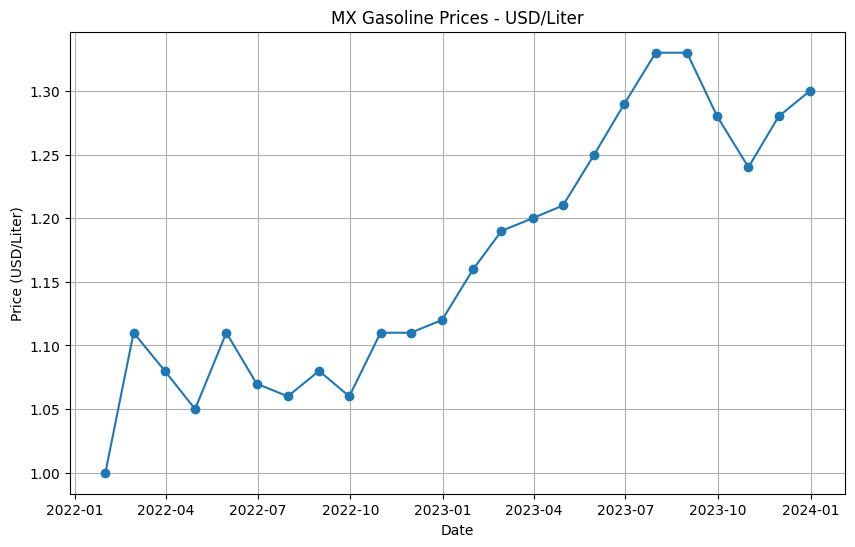

In [5]:
# Datos inferidos
data = {
    'Date': pd.date_range(start='2022-01-01', periods=24, freq='M'),
    'Price (USD/Liter)': [1.00, 1.11, 1.08, 1.05, 1.11, 1.07, 1.06, 1.08, 1.06, 1.11, 1.11, 1.12,
                          1.16, 1.19, 1.20, 1.21, 1.25, 1.29, 1.33, 1.33, 1.28, 1.24, 1.28, 1.30]
}

df = pd.DataFrame(data)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Price (USD/Liter)'], marker='o')
plt.title('MX Gasoline Prices - USD/Liter')
plt.xlabel('Date')
plt.ylabel('Price (USD/Liter)')
plt.grid(True)
plt.show()

C:\Users\ricar\AppData\Local\Temp\ipykernel_14452\3747811391.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Date': pd.date_range(start='2022-01-01', periods=24, freq='M'),


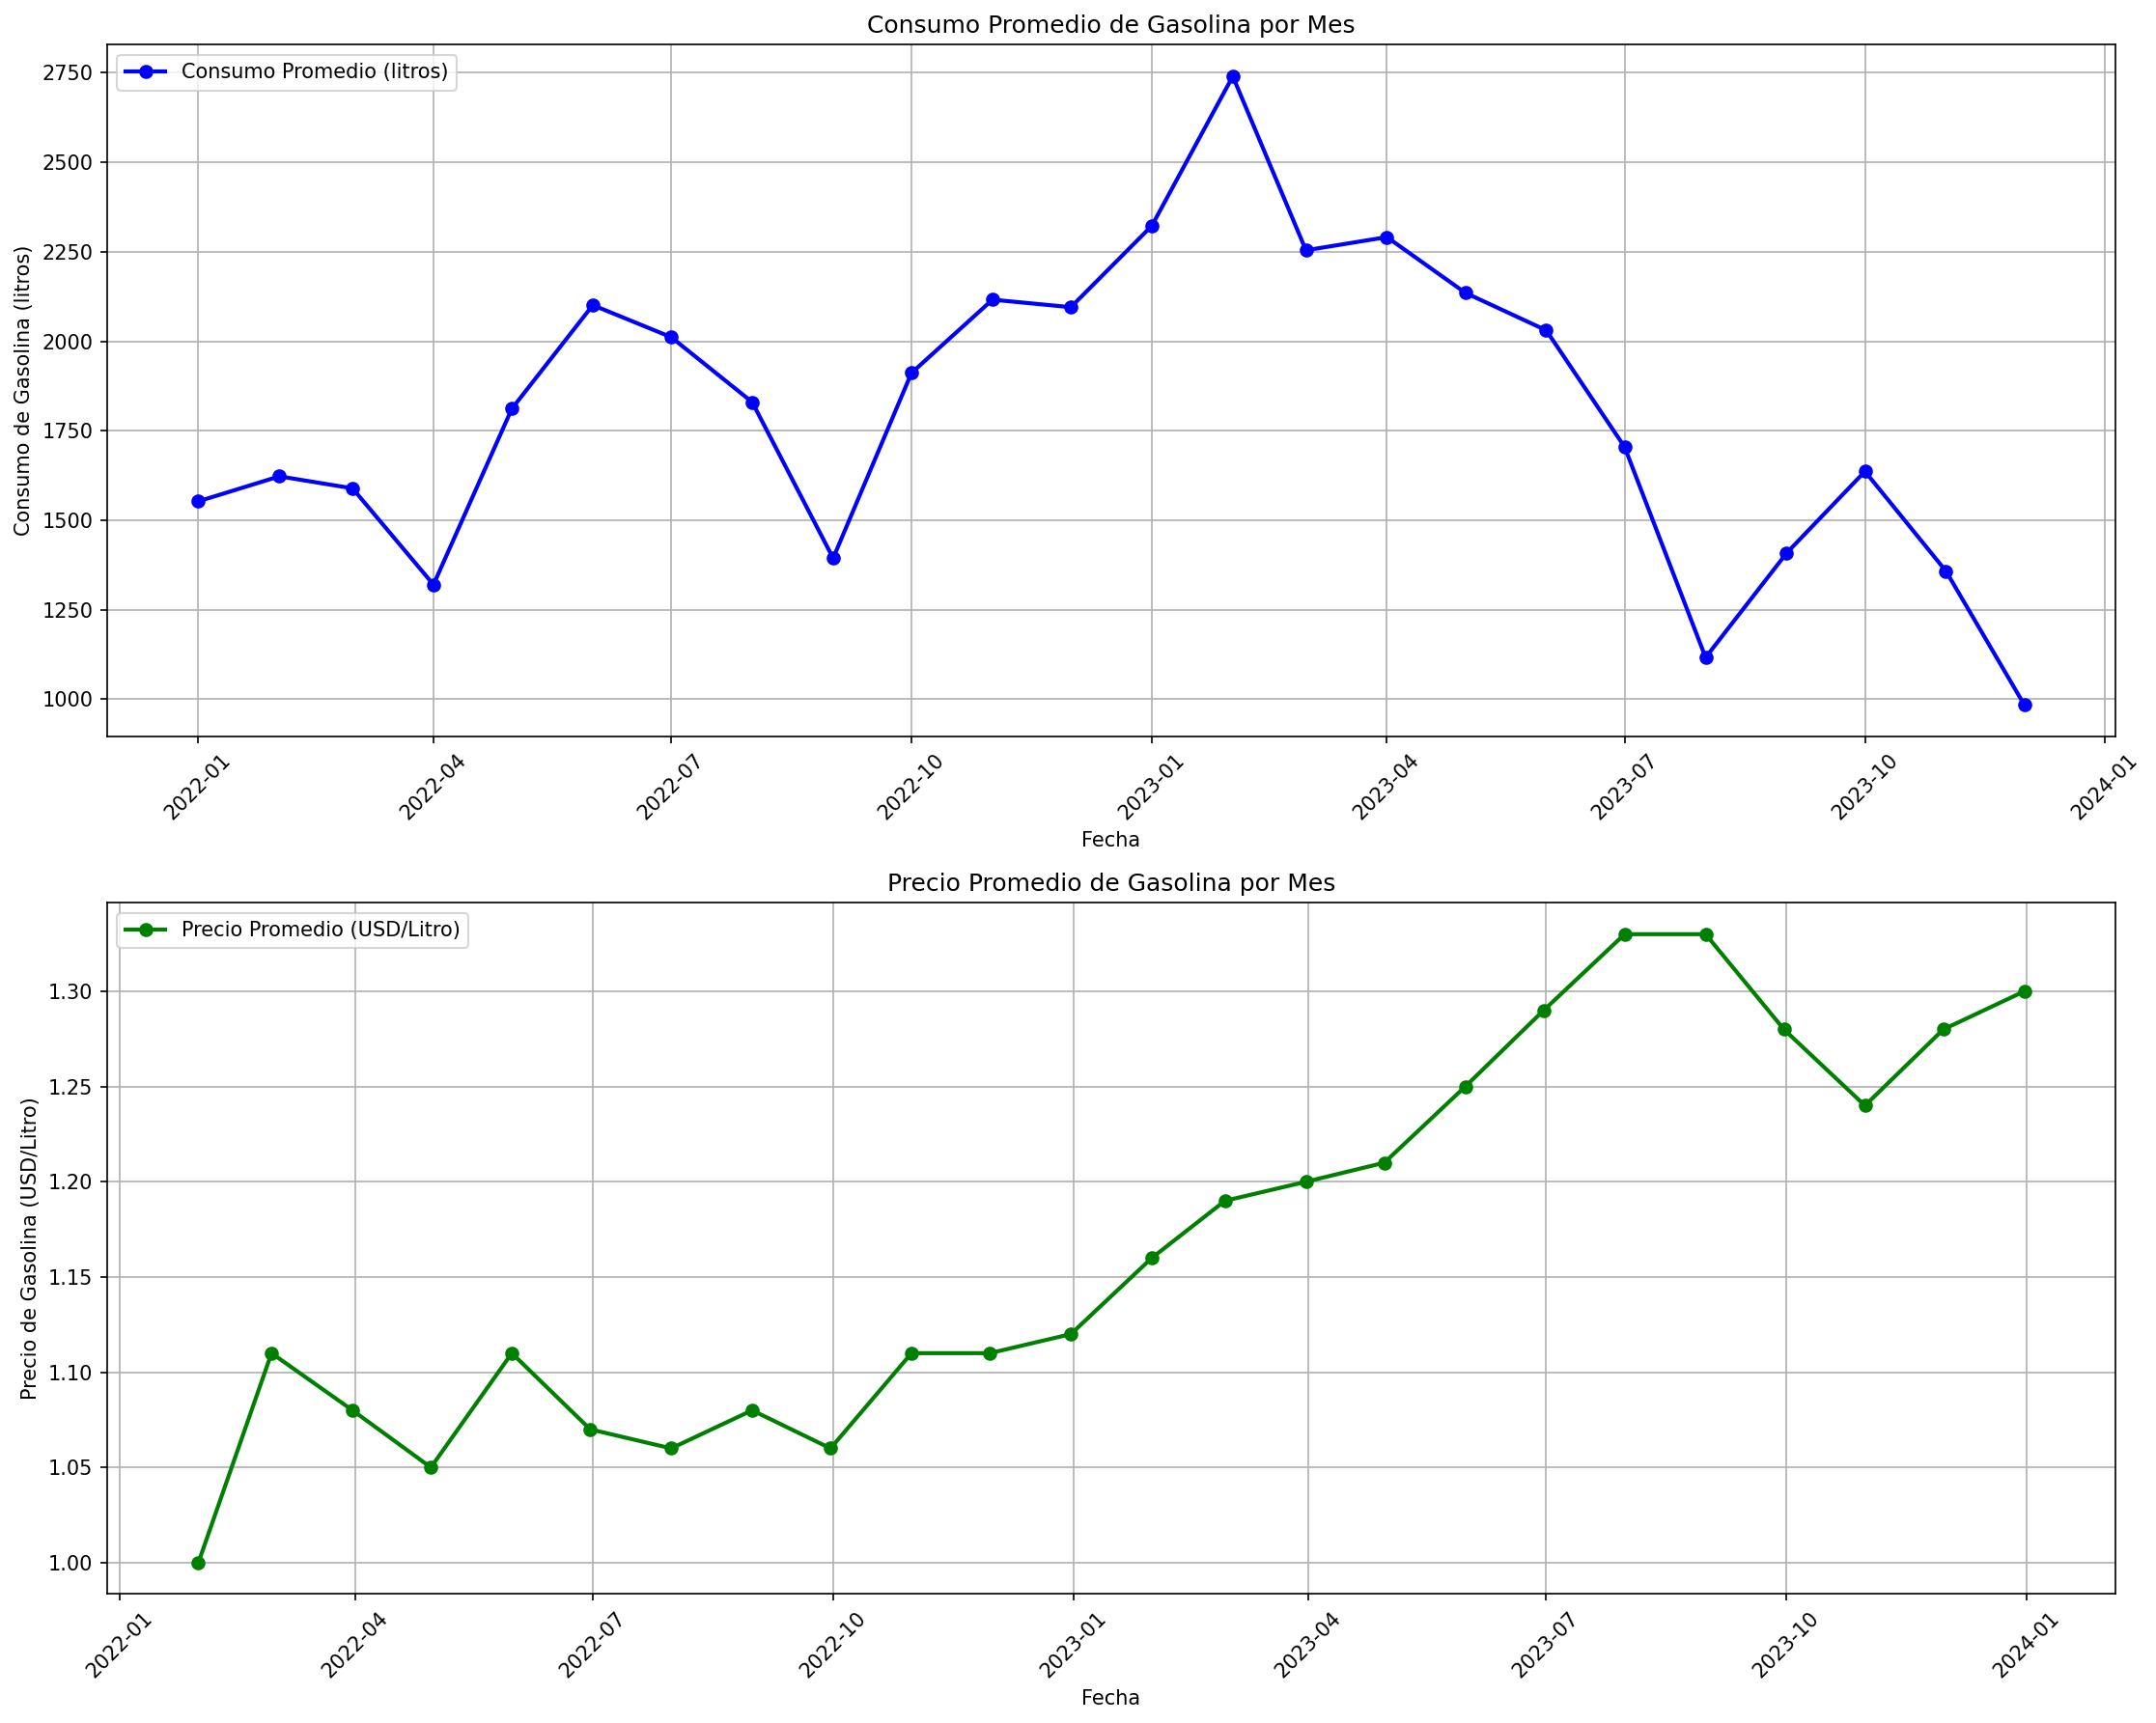

In [26]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
df_vms = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convertir las columnas de fecha y hora a datetime
df_vms['Guardar_Marca'] = pd.to_datetime(df_vms['Guardar_Marca'], errors='coerce')

# Filtrar los puntos con velocidad igual a 0
df_vms = df_vms[df_vms['Etapa_Viaje'] != 'Amarre']

# Ordenar los datos por embarcación y tiempo
df_vms = df_vms.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Crear una columna de geometría a partir de las columnas de longitud y latitud
df_vms['geometry'] = [Point(xy) for xy in zip(df_vms.Longitud, df_vms.Latitud)]
gdf = gpd.GeoDataFrame(df_vms, geometry='geometry')

# Calcular la distancia entre puntos consecutivos en el tiempo para cada embarcación
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Reemplazar NaN en las columnas de distancia y tiempo con 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calcular el consumo de gasolina (litros) basado en la potencia del motor y el tiempo de operación
# Asumimos un consumo de 0.1 galones por hora por cada HP, convertido a litros
gal_to_liters = 3.78
potencia_hp = 100
gdf['Consumo_litros'] = gdf['Tiempo_horas'] * potencia_hp * 0.1 * gal_to_liters

# Identificar y eliminar valores anómalos en el consumo de gasolina
# Aquí, se define como anómalo cualquier valor que esté por encima del percentil 99
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Crear una columna de año-mes
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M').dt.to_timestamp()

# Calcular la distancia total recorrida, el consumo de gasolina y las horas en el mar mensualmente por cada embarcación
distancia_consumo_mensual = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calcular las medias mensuales de distancia recorrida, consumo de gasolina y tiempo en el mar
medias_distancia = distancia_consumo_mensual.groupby('YearMonth')['Distancia_km'].mean()
medias_consumo = distancia_consumo_mensual.groupby('YearMonth')['Consumo_litros'].mean()
medias_tiempo = distancia_consumo_mensual.groupby('YearMonth')['Tiempo_horas'].mean()

# Datos del precio de la gasolina en México (USD/Litro)
data_gas = {
    'Date': pd.date_range(start='2022-01-01', periods=24, freq='M'),
    'Price (USD/Liter)': [1.00, 1.11, 1.08, 1.05, 1.11, 1.07, 1.06, 1.08, 1.06, 1.11, 1.11, 1.12,
                          1.16, 1.19, 1.20, 1.21, 1.25, 1.29, 1.33, 1.33, 1.28, 1.24, 1.28, 1.30]
}

df_gas = pd.DataFrame(data_gas)

# Asegurar que las fechas coinciden exactamente
medias_consumo = medias_consumo.reset_index()
medias_consumo['YearMonth'] = pd.to_datetime(medias_consumo['YearMonth'])
df_gas['Date'] = pd.to_datetime(df_gas['Date'])

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=150)

# Graficar el promedio de consumo de gasolina
ax1.plot(medias_consumo['YearMonth'], medias_consumo['Consumo_litros'], color='blue', marker='o', linestyle='-', linewidth=2, label='Consumo Promedio (litros)')
ax1.set_title('Consumo Promedio de Gasolina por Mes')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Consumo de Gasolina (litros)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Graficar el precio promedio de la gasolina
ax2.plot(df_gas['Date'], df_gas['Price (USD/Liter)'], color='green', marker='o', linestyle='-', linewidth=2, label='Precio Promedio (USD/Litro)')
ax2.set_title('Precio Promedio de Gasolina por Mes')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Precio de Gasolina (USD/Litro)')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


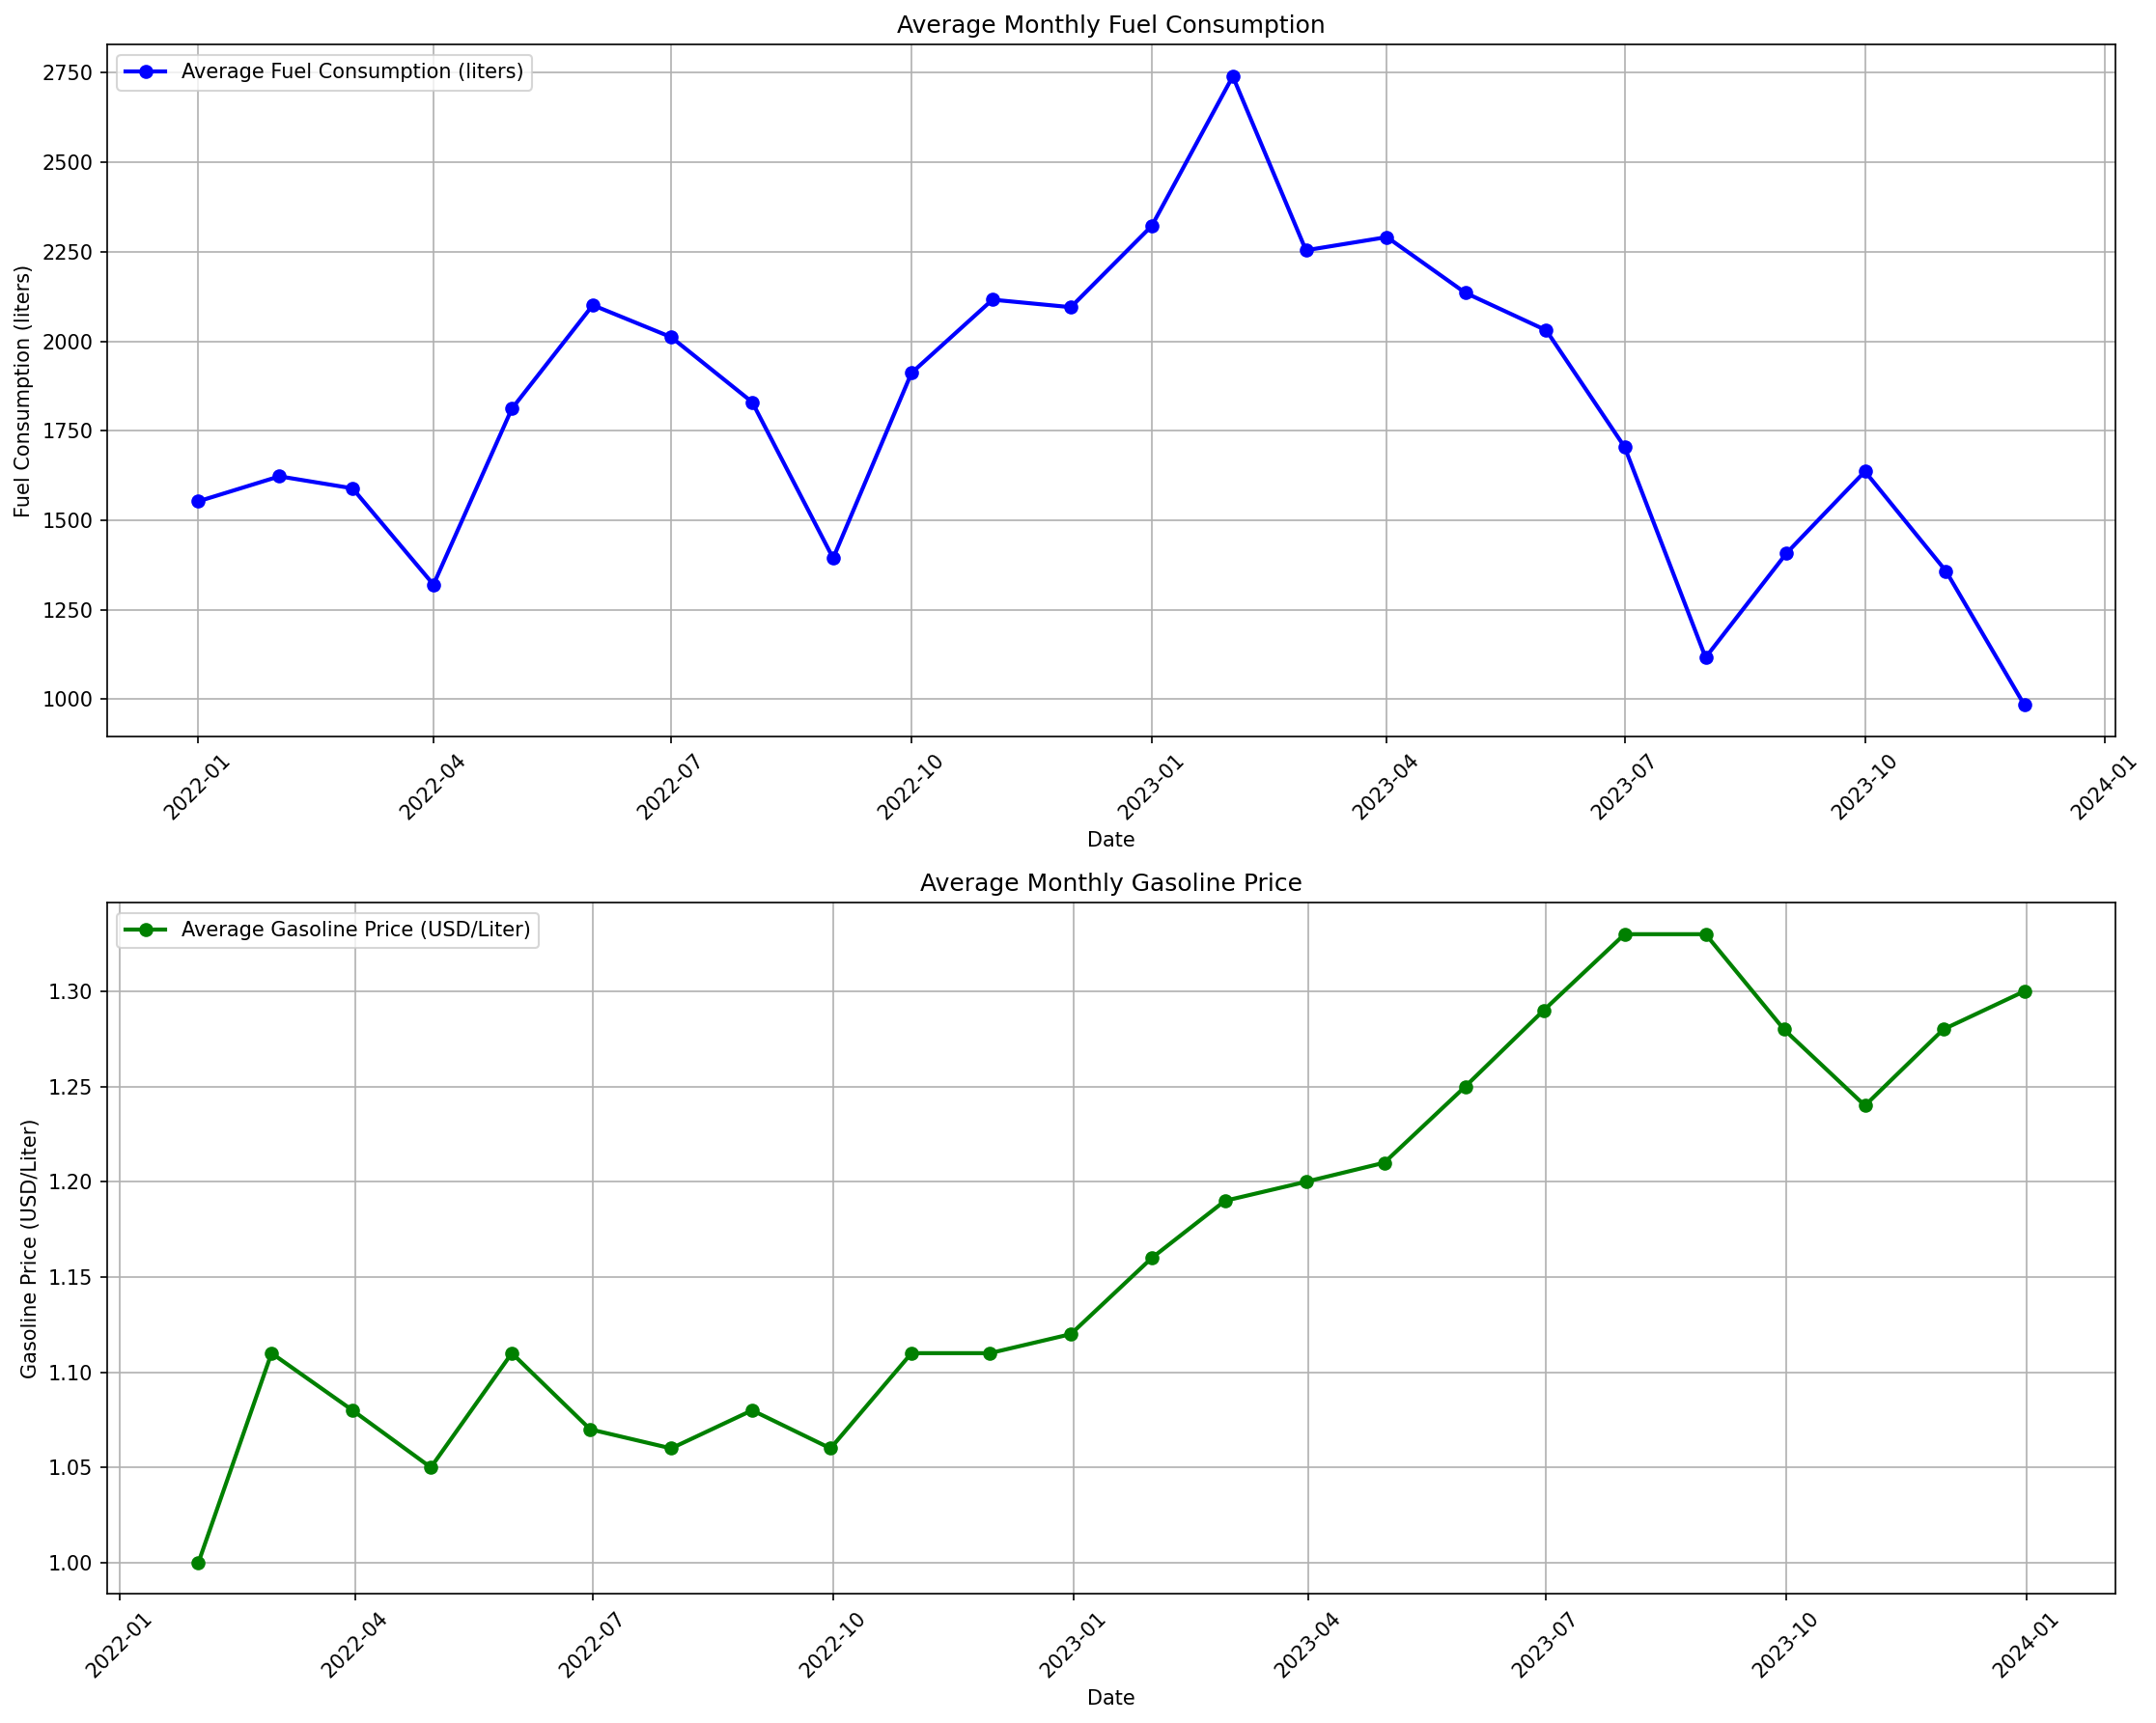

In [28]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
df_vms = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convertir las columnas de fecha y hora a datetime
df_vms['Guardar_Marca'] = pd.to_datetime(df_vms['Guardar_Marca'], errors='coerce')

# Filtrar los puntos con velocidad igual a 0
df_vms = df_vms[df_vms['Etapa_Viaje'] != 'Amarre']

# Ordenar los datos por embarcación y tiempo
df_vms = df_vms.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Crear una columna de geometría a partir de las columnas de longitud y latitud
df_vms['geometry'] = [Point(xy) for xy in zip(df_vms.Longitud, df_vms.Latitud)]
gdf = gpd.GeoDataFrame(df_vms, geometry='geometry')

# Calcular la distancia entre puntos consecutivos en el tiempo para cada embarcación
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Reemplazar NaN en las columnas de distancia y tiempo con 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calcular el consumo de gasolina (litros) basado en la potencia del motor y el tiempo de operación
# Asumimos un consumo de 0.1 galones por hora por cada HP, convertido a litros
gal_to_liters = 3.78
potencia_hp = 100
gdf['Consumo_litros'] = gdf['Tiempo_horas'] * potencia_hp * 0.1 * gal_to_liters

# Identificar y eliminar valores anómalos en el consumo de gasolina
# Aquí, se define como anómalo cualquier valor que esté por encima del percentil 99
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Crear una columna de año-mes
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M').dt.to_timestamp()

# Calcular la distancia total recorrida, el consumo de gasolina y las horas en el mar mensualmente por cada embarcación
distancia_consumo_mensual = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calcular las medias mensuales de distancia recorrida, consumo de gasolina y tiempo en el mar
medias_distancia = distancia_consumo_mensual.groupby('YearMonth')['Distancia_km'].mean()
medias_consumo = distancia_consumo_mensual.groupby('YearMonth')['Consumo_litros'].mean()
medias_tiempo = distancia_consumo_mensual.groupby('YearMonth')['Tiempo_horas'].mean()

# Datos del precio de la gasolina en México (USD/Litro)
data_gas = {
    'Date': pd.date_range(start='2022-01-01', periods=24, freq='ME'),
    'Price (USD/Liter)': [1.00, 1.11, 1.08, 1.05, 1.11, 1.07, 1.06, 1.08, 1.06, 1.11, 1.11, 1.12,
                          1.16, 1.19, 1.20, 1.21, 1.25, 1.29, 1.33, 1.33, 1.28, 1.24, 1.28, 1.30]
}

df_gas = pd.DataFrame(data_gas)

# Asegurar que las fechas coinciden exactamente
medias_consumo = medias_consumo.reset_index()
medias_consumo['YearMonth'] = pd.to_datetime(medias_consumo['YearMonth'])
df_gas['Date'] = pd.to_datetime(df_gas['Date'])

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=150)

# Graficar el promedio de consumo de gasolina
ax1.plot(medias_consumo['YearMonth'], medias_consumo['Consumo_litros'], color='blue', marker='o', linestyle='-', linewidth=2, label='Average Fuel Consumption (liters)')
ax1.set_title('Average Monthly Fuel Consumption')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fuel Consumption (liters)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Graficar el precio promedio de la gasolina
ax2.plot(df_gas['Date'], df_gas['Price (USD/Liter)'], color='green', marker='o', linestyle='-', linewidth=2, label='Average Gasoline Price (USD/Liter)')
ax2.set_title('Average Monthly Gasoline Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Gasoline Price (USD/Liter)')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
